# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 64  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 40000 # Example number of data points
iterations_exp_initial = 1 # Iterations for initial training phase
iterations_exp_long = 500000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5        # beta of softplus
hidden = 256    # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([40000, 64]), psi_samples_exp_tensor shape torch.Size([40000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 117833.203125
iteration 0 loss 100869.5


iteration 500 loss 624.8086547851562


iteration 1000 loss 530.880859375


iteration 1500 loss 461.3887939453125


iteration 2000 loss 417.254150390625


iteration 2500 loss 390.90252685546875


iteration 3000 loss 374.0029296875


iteration 3500 loss 360.52288818359375


iteration 4000 loss 347.60443115234375


iteration 4500 loss 334.54815673828125


iteration 5000 loss 321.4455871582031


iteration 5500 loss 308.43218994140625


iteration 6000 loss 295.5244140625


iteration 6500 loss 282.601318359375


iteration 7000 loss 269.68157958984375


iteration 7500 loss 256.8533020019531


iteration 8000 loss 243.83041381835938


iteration 8500 loss 230.14678955078125


iteration 9000 loss 214.02960205078125


iteration 9500 loss 191.1365203857422


iteration 10000 loss 157.98158264160156


iteration 10500 loss 116.58151245117188


iteration 11000 loss 75.1644287109375


iteration 11500 loss 45.775875091552734


iteration 12000 loss 30.144092559814453


iteration 12500 loss 20.048749923706055


iteration 13000 loss 14.195138931274414


iteration 13500 loss 12.571802139282227


iteration 14000 loss 11.015909194946289


iteration 14500 loss 9.472766876220703


iteration 15000 loss 7.9744553565979


iteration 15500 loss 6.5705952644348145


iteration 16000 loss 9.522939682006836


iteration 16500 loss 5.149391174316406


iteration 17000 loss 4.878518581390381


iteration 17500 loss 4.570677757263184


iteration 18000 loss 4.228420734405518


iteration 18500 loss 3.858553409576416


iteration 19000 loss 3.470886707305908


iteration 19500 loss 3.1368110179901123


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 3.016585111618042


iteration 20500 loss 3.002987861633301


iteration 21000 loss 2.985748291015625


iteration 21500 loss 2.9639317989349365


iteration 22000 loss 2.9364309310913086


iteration 22500 loss 2.9019241333007812


iteration 23000 loss 2.8588404655456543


iteration 23500 loss 2.805441379547119


iteration 24000 loss 2.7399439811706543


iteration 24500 loss 2.6605889797210693


iteration 25000 loss 2.5657122135162354


iteration 25500 loss 2.4541525840759277


iteration 26000 loss 2.3259010314941406


iteration 26500 loss 2.1821963787078857


iteration 27000 loss 2.052703857421875


iteration 27500 loss 2.0091800689697266


iteration 28000 loss 1.956440806388855


iteration 28500 loss 1.8931026458740234


iteration 29000 loss 1.818176507949829


iteration 29500 loss 1.7312878370285034


iteration 30000 loss 1.6497001647949219


iteration 30500 loss 1.607669711112976


iteration 31000 loss 1.5754755735397339


iteration 31500 loss 1.5362187623977661


iteration 32000 loss 1.4889296293258667


iteration 32500 loss 1.4328739643096924


iteration 33000 loss 1.3678103685379028


iteration 33500 loss 1.3395384550094604


iteration 34000 loss 1.3211114406585693


iteration 34500 loss 1.29829740524292


iteration 35000 loss 1.2703685760498047


iteration 35500 loss 1.2365537881851196


iteration 36000 loss 1.1961854696273804


iteration 36500 loss 1.1510565280914307


iteration 37000 loss 1.136818289756775


iteration 37500 loss 1.119731068611145


iteration 38000 loss 1.098673701286316


iteration 38500 loss 1.072975754737854


iteration 39000 loss 1.0420129299163818


iteration 39500 loss 1.0122095346450806


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 1.0021624565124512


iteration 40500 loss 1.0008965730667114


iteration 41000 loss 0.9992759227752686


iteration 41500 loss 0.9971983432769775


iteration 42000 loss 0.9945583939552307


iteration 42500 loss 0.9912087917327881


iteration 43000 loss 0.986985981464386


iteration 43500 loss 0.9816943407058716


iteration 44000 loss 0.9751240015029907


iteration 44500 loss 0.967070460319519


iteration 45000 loss 0.9573601484298706


iteration 45500 loss 0.9459125995635986


iteration 46000 loss 0.9327108263969421


iteration 46500 loss 0.9178687334060669


iteration 47000 loss 0.901559054851532


iteration 47500 loss 0.8843199014663696


iteration 48000 loss 0.8678115010261536


iteration 48500 loss 0.8518097400665283


iteration 49000 loss 0.8365837931632996


iteration 49500 loss 0.8216712474822998


iteration 50000 loss 0.8072661757469177


iteration 50500 loss 0.7934362888336182


iteration 51000 loss 0.7799604535102844


iteration 51500 loss 0.7669574618339539


iteration 52000 loss 0.754386305809021


iteration 52500 loss 0.7420546412467957


iteration 53000 loss 0.7303211688995361


iteration 53500 loss 0.7189542055130005


iteration 54000 loss 0.707490086555481


iteration 54500 loss 0.6965306401252747


iteration 55000 loss 0.6857810616493225


iteration 55500 loss 0.675180971622467


iteration 56000 loss 0.6649960875511169


iteration 56500 loss 0.6551133394241333


iteration 57000 loss 0.6455440521240234


iteration 57500 loss 0.6360846757888794


iteration 58000 loss 0.626834511756897


iteration 58500 loss 0.6177791357040405


iteration 59000 loss 0.6091057658195496


iteration 59500 loss 0.6004111170768738


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.5919853448867798


iteration 60500 loss 0.5911276340484619


iteration 61000 loss 0.590160608291626


iteration 61500 loss 0.5890758037567139


iteration 62000 loss 0.5878912210464478


iteration 62500 loss 0.5866289138793945


iteration 63000 loss 0.5853042602539062


iteration 63500 loss 0.5839328169822693


iteration 64000 loss 0.5825275182723999


iteration 64500 loss 0.5811006426811218


iteration 65000 loss 0.5796608924865723


iteration 65500 loss 0.5782163739204407


iteration 66000 loss 0.5767727494239807


iteration 66500 loss 0.5753346681594849


iteration 67000 loss 0.5739039778709412


iteration 67500 loss 0.5724884867668152


iteration 68000 loss 0.5710868239402771


iteration 68500 loss 0.5696985125541687


iteration 69000 loss 0.5683231949806213


iteration 69500 loss 0.5669577717781067


iteration 70000 loss 0.5656025409698486


iteration 70500 loss 0.5642573237419128


iteration 71000 loss 0.5629211068153381


iteration 71500 loss 0.561594545841217


iteration 72000 loss 0.5602773427963257


iteration 72500 loss 0.5589703917503357


iteration 73000 loss 0.5576716065406799


iteration 73500 loss 0.556381106376648


iteration 74000 loss 0.5550985932350159


iteration 74500 loss 0.553822934627533


iteration 75000 loss 0.5525558590888977


iteration 75500 loss 0.5512949824333191


iteration 76000 loss 0.5500410795211792


iteration 76500 loss 0.5487922430038452


iteration 77000 loss 0.5475515723228455


iteration 77500 loss 0.5463166236877441


iteration 78000 loss 0.5450880527496338


iteration 78500 loss 0.5438658595085144


iteration 79000 loss 0.5426499247550964


iteration 79500 loss 0.5414397120475769


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.5402350425720215


iteration 80500 loss 0.5401201844215393


iteration 81000 loss 0.5400034785270691


iteration 81500 loss 0.5398862361907959


iteration 82000 loss 0.5397682189941406


iteration 82500 loss 0.5396499037742615


iteration 83000 loss 0.539531409740448


iteration 83500 loss 0.5394134521484375


iteration 84000 loss 0.5392946004867554


iteration 84500 loss 0.5391764640808105


iteration 85000 loss 0.5390583872795105


iteration 85500 loss 0.5389400124549866


iteration 86000 loss 0.5388223528862


iteration 86500 loss 0.538705050945282


iteration 87000 loss 0.5385872721672058


iteration 87500 loss 0.5384698510169983


iteration 88000 loss 0.5383525490760803


iteration 88500 loss 0.5382358431816101


iteration 89000 loss 0.5381183624267578


iteration 89500 loss 0.5380017161369324


iteration 90000 loss 0.5378849506378174


iteration 90500 loss 0.5377683639526367


iteration 91000 loss 0.5376521944999695


iteration 91500 loss 0.5375354290008545


iteration 92000 loss 0.5374191999435425


iteration 92500 loss 0.5373033881187439


iteration 93000 loss 0.5371872782707214


iteration 93500 loss 0.5370712876319885


iteration 94000 loss 0.5369555354118347


iteration 94500 loss 0.5368400812149048


iteration 95000 loss 0.536724328994751


iteration 95500 loss 0.5366087555885315


iteration 96000 loss 0.5364935398101807


iteration 96500 loss 0.5363780856132507


iteration 97000 loss 0.5362634658813477


iteration 97500 loss 0.536147952079773


iteration 98000 loss 0.5360332727432251


iteration 98500 loss 0.5359184741973877


iteration 99000 loss 0.5358036160469055


iteration 99500 loss 0.5356888771057129


Learning rate decreased to 1.0000000000000005e-09 at iteration 100000
iteration 100000 loss 0.5355747938156128


iteration 100500 loss 0.5355661511421204


iteration 101000 loss 0.5355575084686279


iteration 101500 loss 0.5355486273765564


iteration 102000 loss 0.5355406403541565


iteration 102500 loss 0.5355316996574402


iteration 103000 loss 0.5355233550071716


iteration 103500 loss 0.5355150699615479


iteration 104000 loss 0.5355063080787659


iteration 104500 loss 0.5354976058006287


iteration 105000 loss 0.535489559173584


iteration 105500 loss 0.5354806780815125


iteration 106000 loss 0.5354724526405334


iteration 106500 loss 0.5354639291763306


iteration 107000 loss 0.5354552865028381


iteration 107500 loss 0.5354466438293457


iteration 108000 loss 0.5354385375976562


iteration 108500 loss 0.5354301333427429


iteration 109000 loss 0.5354217886924744


iteration 109500 loss 0.5354132652282715


iteration 110000 loss 0.5354046821594238


iteration 110500 loss 0.5353966951370239


iteration 111000 loss 0.5353882312774658


iteration 111500 loss 0.5353797674179077


iteration 112000 loss 0.5353713035583496


iteration 112500 loss 0.5353630781173706


iteration 113000 loss 0.5353546738624573


iteration 113500 loss 0.5353461503982544


iteration 114000 loss 0.5353378653526306


iteration 114500 loss 0.5353295207023621


iteration 115000 loss 0.535321056842804


iteration 115500 loss 0.535312294960022


iteration 116000 loss 0.5353044271469116


iteration 116500 loss 0.5352960228919983


iteration 117000 loss 0.535287618637085


iteration 117500 loss 0.5352792143821716


iteration 118000 loss 0.5352709889411926


iteration 118500 loss 0.5352627635002136


iteration 119000 loss 0.5352548956871033


iteration 119500 loss 0.5352464914321899


Learning rate decreased to 1.0000000000000006e-10 at iteration 120000
iteration 120000 loss 0.5352382659912109


iteration 120500 loss 0.5352386832237244


iteration 121000 loss 0.5352381467819214


iteration 121500 loss 0.5352382063865662


iteration 122000 loss 0.5352381467819214


iteration 122500 loss 0.5352379679679871


iteration 123000 loss 0.5352379083633423


iteration 123500 loss 0.5352378487586975


iteration 124000 loss 0.5352377891540527


iteration 124500 loss 0.5352377891540527


iteration 125000 loss 0.5352374911308289


iteration 125500 loss 0.5352374911308289


iteration 126000 loss 0.5352373123168945


iteration 126500 loss 0.5352373123168945


iteration 127000 loss 0.5352368950843811


iteration 127500 loss 0.5352372527122498


iteration 128000 loss 0.5352369546890259


iteration 128500 loss 0.5352370142936707


iteration 129000 loss 0.5352368950843811


iteration 129500 loss 0.5352370738983154


iteration 130000 loss 0.5352367758750916


iteration 130500 loss 0.5352368950843811


iteration 131000 loss 0.5352367758750916


iteration 131500 loss 0.5352364778518677


iteration 132000 loss 0.5352364778518677


iteration 132500 loss 0.5352365374565125


iteration 133000 loss 0.5352362394332886


iteration 133500 loss 0.5352362394332886


iteration 134000 loss 0.5352360606193542


iteration 134500 loss 0.535236120223999


iteration 135000 loss 0.5352358222007751


iteration 135500 loss 0.5352360010147095


iteration 136000 loss 0.5352360010147095


iteration 136500 loss 0.5352360010147095


iteration 137000 loss 0.535235583782196


iteration 137500 loss 0.5352355241775513


iteration 138000 loss 0.5352354645729065


iteration 138500 loss 0.5352354645729065


iteration 139000 loss 0.5352354645729065


iteration 139500 loss 0.5352353453636169


Learning rate decreased to 1.0000000000000006e-11 at iteration 140000
iteration 140000 loss 0.5352353453636169


iteration 140500 loss 0.5352352857589722


iteration 141000 loss 0.5352352857589722


iteration 141500 loss 0.5352352261543274


iteration 142000 loss 0.5352352261543274


iteration 142500 loss 0.5352352857589722


iteration 143000 loss 0.5352354645729065


iteration 143500 loss 0.5352354645729065


iteration 144000 loss 0.5352354645729065


iteration 144500 loss 0.5352354645729065


iteration 145000 loss 0.5352354645729065


iteration 145500 loss 0.5352354049682617


iteration 146000 loss 0.5352354645729065


iteration 146500 loss 0.5352354049682617


iteration 147000 loss 0.5352353453636169


iteration 147500 loss 0.5352354645729065


iteration 148000 loss 0.5352354645729065


iteration 148500 loss 0.5352354645729065


iteration 149000 loss 0.5352355241775513


iteration 149500 loss 0.5352354645729065


iteration 150000 loss 0.5352354049682617


iteration 150500 loss 0.5352354645729065


iteration 151000 loss 0.5352353453636169


iteration 151500 loss 0.5352354645729065


iteration 152000 loss 0.5352354645729065


iteration 152500 loss 0.5352352857589722


iteration 153000 loss 0.5352354645729065


iteration 153500 loss 0.5352352857589722


iteration 154000 loss 0.5352352261543274


iteration 154500 loss 0.5352352261543274


iteration 155000 loss 0.5352353453636169


iteration 155500 loss 0.5352353453636169


iteration 156000 loss 0.5352352261543274


iteration 156500 loss 0.5352352261543274


iteration 157000 loss 0.5352351665496826


iteration 157500 loss 0.5352352261543274


iteration 158000 loss 0.5352351665496826


iteration 158500 loss 0.5352351665496826


iteration 159000 loss 0.5352352261543274


iteration 159500 loss 0.5352354049682617


Learning rate decreased to 1.0000000000000006e-12 at iteration 160000
iteration 160000 loss 0.5352354049682617


iteration 160500 loss 0.5352354049682617


iteration 161000 loss 0.5352354049682617


iteration 161500 loss 0.5352353453636169


iteration 162000 loss 0.5352353453636169


iteration 162500 loss 0.5352354049682617


iteration 163000 loss 0.5352354049682617


iteration 163500 loss 0.5352354049682617


iteration 164000 loss 0.5352354049682617


iteration 164500 loss 0.5352354049682617


iteration 165000 loss 0.5352353453636169


iteration 165500 loss 0.5352354049682617


iteration 166000 loss 0.5352354049682617


iteration 166500 loss 0.5352353453636169


iteration 167000 loss 0.5352353453636169


iteration 167500 loss 0.5352353453636169


iteration 168000 loss 0.5352353453636169


iteration 168500 loss 0.5352354049682617


iteration 169000 loss 0.5352354049682617


iteration 169500 loss 0.5352353453636169


iteration 170000 loss 0.5352353453636169


iteration 170500 loss 0.5352353453636169


iteration 171000 loss 0.5352353453636169


iteration 171500 loss 0.5352353453636169


iteration 172000 loss 0.5352353453636169


iteration 172500 loss 0.5352353453636169


iteration 173000 loss 0.5352353453636169


iteration 173500 loss 0.5352353453636169


iteration 174000 loss 0.5352353453636169


iteration 174500 loss 0.5352353453636169


iteration 175000 loss 0.5352353453636169


iteration 175500 loss 0.5352353453636169


iteration 176000 loss 0.5352353453636169


iteration 176500 loss 0.5352353453636169


iteration 177000 loss 0.5352353453636169


iteration 177500 loss 0.5352353453636169


iteration 178000 loss 0.5352353453636169


iteration 178500 loss 0.5352353453636169


iteration 179000 loss 0.5352353453636169


iteration 179500 loss 0.5352353453636169


Learning rate decreased to 1.0000000000000007e-13 at iteration 180000
iteration 180000 loss 0.5352353453636169


iteration 180500 loss 0.5352353453636169


iteration 181000 loss 0.5352353453636169


iteration 181500 loss 0.5352353453636169


iteration 182000 loss 0.5352353453636169


iteration 182500 loss 0.5352353453636169


iteration 183000 loss 0.5352353453636169


iteration 183500 loss 0.5352353453636169


iteration 184000 loss 0.5352353453636169


iteration 184500 loss 0.5352353453636169


iteration 185000 loss 0.5352353453636169


iteration 185500 loss 0.5352353453636169


iteration 186000 loss 0.5352353453636169


iteration 186500 loss 0.5352353453636169


iteration 187000 loss 0.5352353453636169


iteration 187500 loss 0.5352353453636169


iteration 188000 loss 0.5352353453636169


iteration 188500 loss 0.5352353453636169


iteration 189000 loss 0.5352353453636169


iteration 189500 loss 0.5352353453636169


iteration 190000 loss 0.5352353453636169


iteration 190500 loss 0.5352353453636169


iteration 191000 loss 0.5352353453636169


iteration 191500 loss 0.5352353453636169


iteration 192000 loss 0.5352353453636169


iteration 192500 loss 0.5352353453636169


iteration 193000 loss 0.5352353453636169


iteration 193500 loss 0.5352353453636169


iteration 194000 loss 0.5352353453636169


iteration 194500 loss 0.5352353453636169


iteration 195000 loss 0.5352353453636169


iteration 195500 loss 0.5352353453636169


iteration 196000 loss 0.5352353453636169


iteration 196500 loss 0.5352353453636169


iteration 197000 loss 0.5352353453636169


iteration 197500 loss 0.5352353453636169


iteration 198000 loss 0.5352353453636169


iteration 198500 loss 0.5352353453636169


iteration 199000 loss 0.5352353453636169


iteration 199500 loss 0.5352353453636169


Learning rate decreased to 1.0000000000000008e-14 at iteration 200000
iteration 200000 loss 0.5352353453636169


iteration 200500 loss 0.5352353453636169


iteration 201000 loss 0.5352353453636169


iteration 201500 loss 0.5352353453636169


iteration 202000 loss 0.5352353453636169


iteration 202500 loss 0.5352353453636169


iteration 203000 loss 0.5352353453636169


iteration 203500 loss 0.5352353453636169


iteration 204000 loss 0.5352353453636169


iteration 204500 loss 0.5352353453636169


iteration 205000 loss 0.5352353453636169


iteration 205500 loss 0.5352353453636169


iteration 206000 loss 0.5352353453636169


iteration 206500 loss 0.5352353453636169


iteration 207000 loss 0.5352353453636169


iteration 207500 loss 0.5352353453636169


iteration 208000 loss 0.5352353453636169


iteration 208500 loss 0.5352353453636169


iteration 209000 loss 0.5352353453636169


iteration 209500 loss 0.5352353453636169


iteration 210000 loss 0.5352353453636169


iteration 210500 loss 0.5352353453636169


iteration 211000 loss 0.5352353453636169


iteration 211500 loss 0.5352353453636169


iteration 212000 loss 0.5352353453636169


iteration 212500 loss 0.5352353453636169


iteration 213000 loss 0.5352353453636169


iteration 213500 loss 0.5352353453636169


iteration 214000 loss 0.5352353453636169


iteration 214500 loss 0.5352353453636169


iteration 215000 loss 0.5352353453636169


iteration 215500 loss 0.5352353453636169


iteration 216000 loss 0.5352353453636169


iteration 216500 loss 0.5352353453636169


iteration 217000 loss 0.5352353453636169


iteration 217500 loss 0.5352353453636169


iteration 218000 loss 0.5352353453636169


iteration 218500 loss 0.5352353453636169


iteration 219000 loss 0.5352353453636169


iteration 219500 loss 0.5352353453636169


Learning rate decreased to 1.0000000000000009e-15 at iteration 220000
iteration 220000 loss 0.5352353453636169


iteration 220500 loss 0.5352353453636169


iteration 221000 loss 0.5352353453636169


iteration 221500 loss 0.5352353453636169


iteration 222000 loss 0.5352353453636169


iteration 222500 loss 0.5352353453636169


iteration 223000 loss 0.5352353453636169


iteration 223500 loss 0.5352353453636169


iteration 224000 loss 0.5352353453636169


iteration 224500 loss 0.5352353453636169


iteration 225000 loss 0.5352353453636169


iteration 225500 loss 0.5352353453636169


iteration 226000 loss 0.5352353453636169


iteration 226500 loss 0.5352353453636169


iteration 227000 loss 0.5352353453636169


iteration 227500 loss 0.5352353453636169


iteration 228000 loss 0.5352353453636169


iteration 228500 loss 0.5352353453636169


iteration 229000 loss 0.5352353453636169


iteration 229500 loss 0.5352353453636169


iteration 230000 loss 0.5352353453636169


iteration 230500 loss 0.5352353453636169


iteration 231000 loss 0.5352353453636169


iteration 231500 loss 0.5352353453636169


iteration 232000 loss 0.5352353453636169


iteration 232500 loss 0.5352353453636169


iteration 233000 loss 0.5352353453636169


iteration 233500 loss 0.5352353453636169


iteration 234000 loss 0.5352353453636169


iteration 234500 loss 0.5352353453636169


iteration 235000 loss 0.5352353453636169


iteration 235500 loss 0.5352353453636169


iteration 236000 loss 0.5352353453636169


iteration 236500 loss 0.5352353453636169


iteration 237000 loss 0.5352353453636169


iteration 237500 loss 0.5352353453636169


iteration 238000 loss 0.5352353453636169


iteration 238500 loss 0.5352353453636169


iteration 239000 loss 0.5352353453636169


iteration 239500 loss 0.5352353453636169


Learning rate decreased to 1.000000000000001e-16 at iteration 240000
iteration 240000 loss 0.5352353453636169


iteration 240500 loss 0.5352353453636169


iteration 241000 loss 0.5352353453636169


iteration 241500 loss 0.5352353453636169


iteration 242000 loss 0.5352353453636169


iteration 242500 loss 0.5352353453636169


iteration 243000 loss 0.5352353453636169


iteration 243500 loss 0.5352353453636169


iteration 244000 loss 0.5352353453636169


iteration 244500 loss 0.5352353453636169


iteration 245000 loss 0.5352353453636169


iteration 245500 loss 0.5352353453636169


iteration 246000 loss 0.5352353453636169


iteration 246500 loss 0.5352353453636169


iteration 247000 loss 0.5352353453636169


iteration 247500 loss 0.5352353453636169


iteration 248000 loss 0.5352353453636169


iteration 248500 loss 0.5352353453636169


iteration 249000 loss 0.5352353453636169


iteration 249500 loss 0.5352353453636169


iteration 250000 loss 0.5352353453636169


iteration 250500 loss 0.5352353453636169


iteration 251000 loss 0.5352353453636169


iteration 251500 loss 0.5352353453636169


iteration 252000 loss 0.5352353453636169


iteration 252500 loss 0.5352353453636169


iteration 253000 loss 0.5352353453636169


iteration 253500 loss 0.5352353453636169


iteration 254000 loss 0.5352353453636169


iteration 254500 loss 0.5352353453636169


iteration 255000 loss 0.5352353453636169


iteration 255500 loss 0.5352353453636169


iteration 256000 loss 0.5352353453636169


iteration 256500 loss 0.5352353453636169


iteration 257000 loss 0.5352353453636169


iteration 257500 loss 0.5352353453636169


iteration 258000 loss 0.5352353453636169


iteration 258500 loss 0.5352353453636169


iteration 259000 loss 0.5352353453636169


iteration 259500 loss 0.5352353453636169


Learning rate decreased to 1.000000000000001e-17 at iteration 260000
iteration 260000 loss 0.5352353453636169


iteration 260500 loss 0.5352353453636169


iteration 261000 loss 0.5352353453636169


iteration 261500 loss 0.5352353453636169


iteration 262000 loss 0.5352353453636169


iteration 262500 loss 0.5352353453636169


iteration 263000 loss 0.5352353453636169


iteration 263500 loss 0.5352353453636169


iteration 264000 loss 0.5352353453636169


iteration 264500 loss 0.5352353453636169


iteration 265000 loss 0.5352353453636169


iteration 265500 loss 0.5352353453636169


iteration 266000 loss 0.5352353453636169


iteration 266500 loss 0.5352353453636169


iteration 267000 loss 0.5352353453636169


iteration 267500 loss 0.5352353453636169


iteration 268000 loss 0.5352353453636169


iteration 268500 loss 0.5352353453636169


iteration 269000 loss 0.5352353453636169


iteration 269500 loss 0.5352353453636169


iteration 270000 loss 0.5352353453636169


iteration 270500 loss 0.5352353453636169


iteration 271000 loss 0.5352353453636169


iteration 271500 loss 0.5352353453636169


iteration 272000 loss 0.5352353453636169


iteration 272500 loss 0.5352353453636169


iteration 273000 loss 0.5352353453636169


iteration 273500 loss 0.5352353453636169


iteration 274000 loss 0.5352353453636169


iteration 274500 loss 0.5352353453636169


iteration 275000 loss 0.5352353453636169


iteration 275500 loss 0.5352353453636169


iteration 276000 loss 0.5352353453636169


iteration 276500 loss 0.5352353453636169


iteration 277000 loss 0.5352353453636169


iteration 277500 loss 0.5352353453636169


iteration 278000 loss 0.5352353453636169


iteration 278500 loss 0.5352353453636169


iteration 279000 loss 0.5352353453636169


iteration 279500 loss 0.5352353453636169


Learning rate decreased to 1.000000000000001e-18 at iteration 280000
iteration 280000 loss 0.5352353453636169


iteration 280500 loss 0.5352353453636169


iteration 281000 loss 0.5352353453636169


iteration 281500 loss 0.5352353453636169


iteration 282000 loss 0.5352353453636169


iteration 282500 loss 0.5352353453636169


iteration 283000 loss 0.5352353453636169


iteration 283500 loss 0.5352353453636169


iteration 284000 loss 0.5352353453636169


iteration 284500 loss 0.5352353453636169


iteration 285000 loss 0.5352353453636169


iteration 285500 loss 0.5352353453636169


iteration 286000 loss 0.5352353453636169


iteration 286500 loss 0.5352353453636169


iteration 287000 loss 0.5352353453636169


iteration 287500 loss 0.5352353453636169


iteration 288000 loss 0.5352353453636169


iteration 288500 loss 0.5352353453636169


iteration 289000 loss 0.5352353453636169


iteration 289500 loss 0.5352353453636169


iteration 290000 loss 0.5352353453636169


iteration 290500 loss 0.5352353453636169


iteration 291000 loss 0.5352353453636169


iteration 291500 loss 0.5352353453636169


iteration 292000 loss 0.5352353453636169


iteration 292500 loss 0.5352353453636169


iteration 293000 loss 0.5352353453636169


iteration 293500 loss 0.5352353453636169


iteration 294000 loss 0.5352353453636169


iteration 294500 loss 0.5352353453636169


iteration 295000 loss 0.5352353453636169


iteration 295500 loss 0.5352353453636169


iteration 296000 loss 0.5352353453636169


iteration 296500 loss 0.5352353453636169


iteration 297000 loss 0.5352353453636169


iteration 297500 loss 0.5352353453636169


iteration 298000 loss 0.5352353453636169


iteration 298500 loss 0.5352353453636169


iteration 299000 loss 0.5352353453636169


iteration 299500 loss 0.5352353453636169


Learning rate decreased to 1.000000000000001e-19 at iteration 300000
iteration 300000 loss 0.5352353453636169


iteration 300500 loss 0.5352353453636169


iteration 301000 loss 0.5352353453636169


iteration 301500 loss 0.5352353453636169


iteration 302000 loss 0.5352353453636169


iteration 302500 loss 0.5352353453636169


iteration 303000 loss 0.5352353453636169


iteration 303500 loss 0.5352353453636169


iteration 304000 loss 0.5352353453636169


iteration 304500 loss 0.5352353453636169


iteration 305000 loss 0.5352353453636169


iteration 305500 loss 0.5352353453636169


iteration 306000 loss 0.5352353453636169


iteration 306500 loss 0.5352353453636169


iteration 307000 loss 0.5352353453636169


iteration 307500 loss 0.5352353453636169


iteration 308000 loss 0.5352353453636169


iteration 308500 loss 0.5352353453636169


iteration 309000 loss 0.5352353453636169


iteration 309500 loss 0.5352353453636169


iteration 310000 loss 0.5352353453636169


iteration 310500 loss 0.5352353453636169


iteration 311000 loss 0.5352353453636169


iteration 311500 loss 0.5352353453636169


iteration 312000 loss 0.5352353453636169


iteration 312500 loss 0.5352353453636169


iteration 313000 loss 0.5352353453636169


iteration 313500 loss 0.5352353453636169


iteration 314000 loss 0.5352353453636169


iteration 314500 loss 0.5352353453636169


iteration 315000 loss 0.5352353453636169


iteration 315500 loss 0.5352353453636169


iteration 316000 loss 0.5352353453636169


iteration 316500 loss 0.5352353453636169


iteration 317000 loss 0.5352353453636169


iteration 317500 loss 0.5352353453636169


iteration 318000 loss 0.5352353453636169


iteration 318500 loss 0.5352353453636169


iteration 319000 loss 0.5352353453636169


iteration 319500 loss 0.5352353453636169


Learning rate decreased to 1.0000000000000011e-20 at iteration 320000
iteration 320000 loss 0.5352353453636169


iteration 320500 loss 0.5352353453636169


iteration 321000 loss 0.5352353453636169


iteration 321500 loss 0.5352353453636169


iteration 322000 loss 0.5352353453636169


iteration 322500 loss 0.5352353453636169


iteration 323000 loss 0.5352353453636169


iteration 323500 loss 0.5352353453636169


iteration 324000 loss 0.5352353453636169


iteration 324500 loss 0.5352353453636169


iteration 325000 loss 0.5352353453636169


iteration 325500 loss 0.5352353453636169


iteration 326000 loss 0.5352353453636169


iteration 326500 loss 0.5352353453636169


iteration 327000 loss 0.5352353453636169


iteration 327500 loss 0.5352353453636169


iteration 328000 loss 0.5352353453636169


iteration 328500 loss 0.5352353453636169


iteration 329000 loss 0.5352353453636169


iteration 329500 loss 0.5352353453636169


iteration 330000 loss 0.5352353453636169


iteration 330500 loss 0.5352353453636169


iteration 331000 loss 0.5352353453636169


iteration 331500 loss 0.5352353453636169


iteration 332000 loss 0.5352353453636169


iteration 332500 loss 0.5352353453636169


iteration 333000 loss 0.5352353453636169


iteration 333500 loss 0.5352353453636169


iteration 334000 loss 0.5352353453636169


iteration 334500 loss 0.5352353453636169


iteration 335000 loss 0.5352353453636169


iteration 335500 loss 0.5352353453636169


iteration 336000 loss 0.5352353453636169


iteration 336500 loss 0.5352353453636169


iteration 337000 loss 0.5352353453636169


iteration 337500 loss 0.5352353453636169


iteration 338000 loss 0.5352353453636169


iteration 338500 loss 0.5352353453636169


iteration 339000 loss 0.5352353453636169


iteration 339500 loss 0.5352353453636169


Learning rate decreased to 1.0000000000000012e-21 at iteration 340000
iteration 340000 loss 0.5352353453636169


iteration 340500 loss 0.5352353453636169


iteration 341000 loss 0.5352353453636169


iteration 341500 loss 0.5352353453636169


iteration 342000 loss 0.5352353453636169


iteration 342500 loss 0.5352353453636169


iteration 343000 loss 0.5352353453636169


iteration 343500 loss 0.5352353453636169


iteration 344000 loss 0.5352353453636169


iteration 344500 loss 0.5352353453636169


iteration 345000 loss 0.5352353453636169


iteration 345500 loss 0.5352353453636169


iteration 346000 loss 0.5352353453636169


iteration 346500 loss 0.5352353453636169


iteration 347000 loss 0.5352353453636169


iteration 347500 loss 0.5352353453636169


iteration 348000 loss 0.5352353453636169


iteration 348500 loss 0.5352353453636169


iteration 349000 loss 0.5352353453636169


iteration 349500 loss 0.5352353453636169


iteration 350000 loss 0.5352353453636169


iteration 350500 loss 0.5352353453636169


iteration 351000 loss 0.5352353453636169


iteration 351500 loss 0.5352353453636169


iteration 352000 loss 0.5352353453636169


iteration 352500 loss 0.5352353453636169


iteration 353000 loss 0.5352353453636169


iteration 353500 loss 0.5352353453636169


iteration 354000 loss 0.5352353453636169


iteration 354500 loss 0.5352353453636169


iteration 355000 loss 0.5352353453636169


iteration 355500 loss 0.5352353453636169


iteration 356000 loss 0.5352353453636169


iteration 356500 loss 0.5352353453636169


iteration 357000 loss 0.5352353453636169


iteration 357500 loss 0.5352353453636169


iteration 358000 loss 0.5352353453636169


iteration 358500 loss 0.5352353453636169


iteration 359000 loss 0.5352353453636169


iteration 359500 loss 0.5352353453636169


Learning rate decreased to 1.0000000000000012e-22 at iteration 360000
iteration 360000 loss 0.5352353453636169


iteration 360500 loss 0.5352353453636169


iteration 361000 loss 0.5352353453636169


iteration 361500 loss 0.5352353453636169


iteration 362000 loss 0.5352353453636169


iteration 362500 loss 0.5352353453636169


iteration 363000 loss 0.5352353453636169


iteration 363500 loss 0.5352353453636169


iteration 364000 loss 0.5352353453636169


iteration 364500 loss 0.5352353453636169


iteration 365000 loss 0.5352353453636169


iteration 365500 loss 0.5352353453636169


iteration 366000 loss 0.5352353453636169


iteration 366500 loss 0.5352353453636169


iteration 367000 loss 0.5352353453636169


iteration 367500 loss 0.5352353453636169


iteration 368000 loss 0.5352353453636169


iteration 368500 loss 0.5352353453636169


iteration 369000 loss 0.5352353453636169


iteration 369500 loss 0.5352353453636169


iteration 370000 loss 0.5352353453636169


iteration 370500 loss 0.5352353453636169


iteration 371000 loss 0.5352353453636169


iteration 371500 loss 0.5352353453636169


iteration 372000 loss 0.5352353453636169


iteration 372500 loss 0.5352353453636169


iteration 373000 loss 0.5352353453636169


iteration 373500 loss 0.5352353453636169


iteration 374000 loss 0.5352353453636169


iteration 374500 loss 0.5352353453636169


iteration 375000 loss 0.5352353453636169


iteration 375500 loss 0.5352353453636169


iteration 376000 loss 0.5352353453636169


iteration 376500 loss 0.5352353453636169


iteration 377000 loss 0.5352353453636169


iteration 377500 loss 0.5352353453636169


iteration 378000 loss 0.5352353453636169


iteration 378500 loss 0.5352353453636169


iteration 379000 loss 0.5352353453636169


iteration 379500 loss 0.5352353453636169


Learning rate decreased to 1.0000000000000013e-23 at iteration 380000
iteration 380000 loss 0.5352353453636169


iteration 380500 loss 0.5352353453636169


iteration 381000 loss 0.5352353453636169


iteration 381500 loss 0.5352353453636169


iteration 382000 loss 0.5352353453636169


iteration 382500 loss 0.5352353453636169


iteration 383000 loss 0.5352353453636169


iteration 383500 loss 0.5352353453636169


iteration 384000 loss 0.5352353453636169


iteration 384500 loss 0.5352353453636169


iteration 385000 loss 0.5352353453636169


iteration 385500 loss 0.5352353453636169


iteration 386000 loss 0.5352353453636169


iteration 386500 loss 0.5352353453636169


iteration 387000 loss 0.5352353453636169


iteration 387500 loss 0.5352353453636169


iteration 388000 loss 0.5352353453636169


iteration 388500 loss 0.5352353453636169


iteration 389000 loss 0.5352353453636169


iteration 389500 loss 0.5352353453636169


iteration 390000 loss 0.5352353453636169


iteration 390500 loss 0.5352353453636169


iteration 391000 loss 0.5352353453636169


iteration 391500 loss 0.5352353453636169


iteration 392000 loss 0.5352353453636169


iteration 392500 loss 0.5352353453636169


iteration 393000 loss 0.5352353453636169


iteration 393500 loss 0.5352353453636169


iteration 394000 loss 0.5352353453636169


iteration 394500 loss 0.5352353453636169


iteration 395000 loss 0.5352353453636169


iteration 395500 loss 0.5352353453636169


iteration 396000 loss 0.5352353453636169


iteration 396500 loss 0.5352353453636169


iteration 397000 loss 0.5352353453636169


iteration 397500 loss 0.5352353453636169


iteration 398000 loss 0.5352353453636169


iteration 398500 loss 0.5352353453636169


iteration 399000 loss 0.5352353453636169


iteration 399500 loss 0.5352353453636169


Learning rate decreased to 1.0000000000000014e-24 at iteration 400000
iteration 400000 loss 0.5352353453636169


iteration 400500 loss 0.5352353453636169


iteration 401000 loss 0.5352353453636169


iteration 401500 loss 0.5352353453636169


iteration 402000 loss 0.5352353453636169


iteration 402500 loss 0.5352353453636169


iteration 403000 loss 0.5352353453636169


iteration 403500 loss 0.5352353453636169


iteration 404000 loss 0.5352353453636169


iteration 404500 loss 0.5352353453636169


iteration 405000 loss 0.5352353453636169


iteration 405500 loss 0.5352353453636169


iteration 406000 loss 0.5352353453636169


iteration 406500 loss 0.5352353453636169


iteration 407000 loss 0.5352353453636169


iteration 407500 loss 0.5352353453636169


iteration 408000 loss 0.5352353453636169


iteration 408500 loss 0.5352353453636169


iteration 409000 loss 0.5352353453636169


iteration 409500 loss 0.5352353453636169


iteration 410000 loss 0.5352353453636169


iteration 410500 loss 0.5352353453636169


iteration 411000 loss 0.5352353453636169


iteration 411500 loss 0.5352353453636169


iteration 412000 loss 0.5352353453636169


iteration 412500 loss 0.5352353453636169


iteration 413000 loss 0.5352353453636169


iteration 413500 loss 0.5352353453636169


iteration 414000 loss 0.5352353453636169


iteration 414500 loss 0.5352353453636169


iteration 415000 loss 0.5352353453636169


iteration 415500 loss 0.5352353453636169


iteration 416000 loss 0.5352353453636169


iteration 416500 loss 0.5352353453636169


iteration 417000 loss 0.5352353453636169


iteration 417500 loss 0.5352353453636169


iteration 418000 loss 0.5352353453636169


iteration 418500 loss 0.5352353453636169


iteration 419000 loss 0.5352353453636169


iteration 419500 loss 0.5352353453636169


Learning rate decreased to 1.0000000000000014e-25 at iteration 420000
iteration 420000 loss 0.5352353453636169


iteration 420500 loss 0.5352353453636169


iteration 421000 loss 0.5352353453636169


iteration 421500 loss 0.5352353453636169


iteration 422000 loss 0.5352353453636169


iteration 422500 loss 0.5352353453636169


iteration 423000 loss 0.5352353453636169


iteration 423500 loss 0.5352353453636169


iteration 424000 loss 0.5352353453636169


iteration 424500 loss 0.5352353453636169


iteration 425000 loss 0.5352353453636169


iteration 425500 loss 0.5352353453636169


iteration 426000 loss 0.5352353453636169


iteration 426500 loss 0.5352353453636169


iteration 427000 loss 0.5352353453636169


iteration 427500 loss 0.5352353453636169


iteration 428000 loss 0.5352353453636169


iteration 428500 loss 0.5352353453636169


iteration 429000 loss 0.5352353453636169


iteration 429500 loss 0.5352353453636169


iteration 430000 loss 0.5352353453636169


iteration 430500 loss 0.5352353453636169


iteration 431000 loss 0.5352353453636169


iteration 431500 loss 0.5352353453636169


iteration 432000 loss 0.5352353453636169


iteration 432500 loss 0.5352353453636169


iteration 433000 loss 0.5352353453636169


iteration 433500 loss 0.5352353453636169


iteration 434000 loss 0.5352353453636169


iteration 434500 loss 0.5352353453636169


iteration 435000 loss 0.5352353453636169


iteration 435500 loss 0.5352353453636169


iteration 436000 loss 0.5352353453636169


iteration 436500 loss 0.5352353453636169


iteration 437000 loss 0.5352353453636169


iteration 437500 loss 0.5352353453636169


iteration 438000 loss 0.5352353453636169


iteration 438500 loss 0.5352353453636169


iteration 439000 loss 0.5352353453636169


iteration 439500 loss 0.5352353453636169


Learning rate decreased to 1.0000000000000015e-26 at iteration 440000
iteration 440000 loss 0.5352353453636169


iteration 440500 loss 0.5352353453636169


iteration 441000 loss 0.5352353453636169


iteration 441500 loss 0.5352353453636169


iteration 442000 loss 0.5352353453636169


iteration 442500 loss 0.5352353453636169


iteration 443000 loss 0.5352353453636169


iteration 443500 loss 0.5352353453636169


iteration 444000 loss 0.5352353453636169


iteration 444500 loss 0.5352353453636169


iteration 445000 loss 0.5352353453636169


iteration 445500 loss 0.5352353453636169


iteration 446000 loss 0.5352353453636169


iteration 446500 loss 0.5352353453636169


iteration 447000 loss 0.5352353453636169


iteration 447500 loss 0.5352353453636169


iteration 448000 loss 0.5352353453636169


iteration 448500 loss 0.5352353453636169


iteration 449000 loss 0.5352353453636169


iteration 449500 loss 0.5352353453636169


iteration 450000 loss 0.5352353453636169


iteration 450500 loss 0.5352353453636169


iteration 451000 loss 0.5352353453636169


iteration 451500 loss 0.5352353453636169


iteration 452000 loss 0.5352353453636169


iteration 452500 loss 0.5352353453636169


iteration 453000 loss 0.5352353453636169


iteration 453500 loss 0.5352353453636169


iteration 454000 loss 0.5352353453636169


iteration 454500 loss 0.5352353453636169


iteration 455000 loss 0.5352353453636169


iteration 455500 loss 0.5352353453636169


iteration 456000 loss 0.5352353453636169


iteration 456500 loss 0.5352353453636169


iteration 457000 loss 0.5352353453636169


iteration 457500 loss 0.5352353453636169


iteration 458000 loss 0.5352353453636169


iteration 458500 loss 0.5352353453636169


iteration 459000 loss 0.5352353453636169


iteration 459500 loss 0.5352353453636169


Learning rate decreased to 1.0000000000000015e-27 at iteration 460000
iteration 460000 loss 0.5352353453636169


iteration 460500 loss 0.5352353453636169


iteration 461000 loss 0.5352353453636169


iteration 461500 loss 0.5352353453636169


iteration 462000 loss 0.5352353453636169


iteration 462500 loss 0.5352353453636169


iteration 463000 loss 0.5352353453636169


iteration 463500 loss 0.5352353453636169


iteration 464000 loss 0.5352353453636169


iteration 464500 loss 0.5352353453636169


iteration 465000 loss 0.5352353453636169


iteration 465500 loss 0.5352353453636169


iteration 466000 loss 0.5352353453636169


iteration 466500 loss 0.5352353453636169


iteration 467000 loss 0.5352353453636169


iteration 467500 loss 0.5352353453636169


iteration 468000 loss 0.5352353453636169


iteration 468500 loss 0.5352353453636169


iteration 469000 loss 0.5352353453636169


iteration 469500 loss 0.5352353453636169


iteration 470000 loss 0.5352353453636169


iteration 470500 loss 0.5352353453636169


iteration 471000 loss 0.5352353453636169


iteration 471500 loss 0.5352353453636169


iteration 472000 loss 0.5352353453636169


iteration 472500 loss 0.5352353453636169


iteration 473000 loss 0.5352353453636169


iteration 473500 loss 0.5352353453636169


iteration 474000 loss 0.5352353453636169


iteration 474500 loss 0.5352353453636169


iteration 475000 loss 0.5352353453636169


iteration 475500 loss 0.5352353453636169


iteration 476000 loss 0.5352353453636169


iteration 476500 loss 0.5352353453636169


iteration 477000 loss 0.5352353453636169


iteration 477500 loss 0.5352353453636169


iteration 478000 loss 0.5352353453636169


iteration 478500 loss 0.5352353453636169


iteration 479000 loss 0.5352353453636169


iteration 479500 loss 0.5352353453636169


Learning rate decreased to 1.0000000000000015e-28 at iteration 480000
iteration 480000 loss 0.5352353453636169


iteration 480500 loss 0.5352353453636169


iteration 481000 loss 0.5352353453636169


iteration 481500 loss 0.5352353453636169


iteration 482000 loss 0.5352353453636169


iteration 482500 loss 0.5352353453636169


iteration 483000 loss 0.5352353453636169


iteration 483500 loss 0.5352353453636169


iteration 484000 loss 0.5352353453636169


iteration 484500 loss 0.5352353453636169


iteration 485000 loss 0.5352353453636169


iteration 485500 loss 0.5352353453636169


iteration 486000 loss 0.5352353453636169


iteration 486500 loss 0.5352353453636169


iteration 487000 loss 0.5352353453636169


iteration 487500 loss 0.5352353453636169


iteration 488000 loss 0.5352353453636169


iteration 488500 loss 0.5352353453636169


iteration 489000 loss 0.5352353453636169


iteration 489500 loss 0.5352353453636169


iteration 490000 loss 0.5352353453636169


iteration 490500 loss 0.5352353453636169


iteration 491000 loss 0.5352353453636169


iteration 491500 loss 0.5352353453636169


iteration 492000 loss 0.5352353453636169


iteration 492500 loss 0.5352353453636169


iteration 493000 loss 0.5352353453636169


iteration 493500 loss 0.5352353453636169


iteration 494000 loss 0.5352353453636169


iteration 494500 loss 0.5352353453636169


iteration 495000 loss 0.5352353453636169


iteration 495500 loss 0.5352353453636169


iteration 496000 loss 0.5352353453636169


iteration 496500 loss 0.5352353453636169


iteration 497000 loss 0.5352353453636169


iteration 497500 loss 0.5352353453636169


iteration 498000 loss 0.5352353453636169


iteration 498500 loss 0.5352353453636169


iteration 499000 loss 0.5352353453636169


iteration 499500 loss 0.5352353453636169


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=64) ---
loss -2.726754665374756


loss -106.59172821044922


loss -155.95687866210938


loss -196.56036376953125


loss -232.22352600097656


loss -262.369873046875


loss -285.90252685546875


loss -302.0198669433594


loss -311.1072692871094


loss -315.04229736328125


loss -316.25604248046875


loss -316.5010681152344


loss -316.53045654296875


loss -316.5323181152344


loss -316.5323486328125


loss -316.5323486328125


loss -316.5323486328125


loss -316.5323791503906


loss -316.5323486328125


loss -316.5323486328125


loss -316.5323791503906


loss -316.5323486328125


loss -316.5323791503906


loss -316.5323486328125


loss -316.5323486328125


loss -316.5323486328125


loss -316.5323486328125


loss -316.5323486328125


loss -316.5323486328125


loss -316.5323486328125


loss -316.5323486328125


loss -316.5323486328125


loss -316.5323486328125


loss -316.5323486328125


loss -316.5323486328125


loss -316.5323486328125


loss -316.5323486328125


loss -316.5323791503906


loss -316.5323791503906


loss -316.5323486328125


final mse:  7.199497109589004e-10
max, min: 4.3150725 -3.8941095
loss -2.726754665374756


loss -106.67642211914062


loss -155.9037628173828


loss -196.26531982421875


loss -231.6966552734375


loss -261.5640563964844


loss -284.75714111328125


loss -300.5538330078125


loss -309.42266845703125


loss -313.25970458984375


loss -314.4580993652344


loss -314.7109375


loss -314.7442321777344


loss -314.7467041015625


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


loss -314.74676513671875


final mse:  5.565315985833763e-10
max, min: 4.3271837 -3.8673294


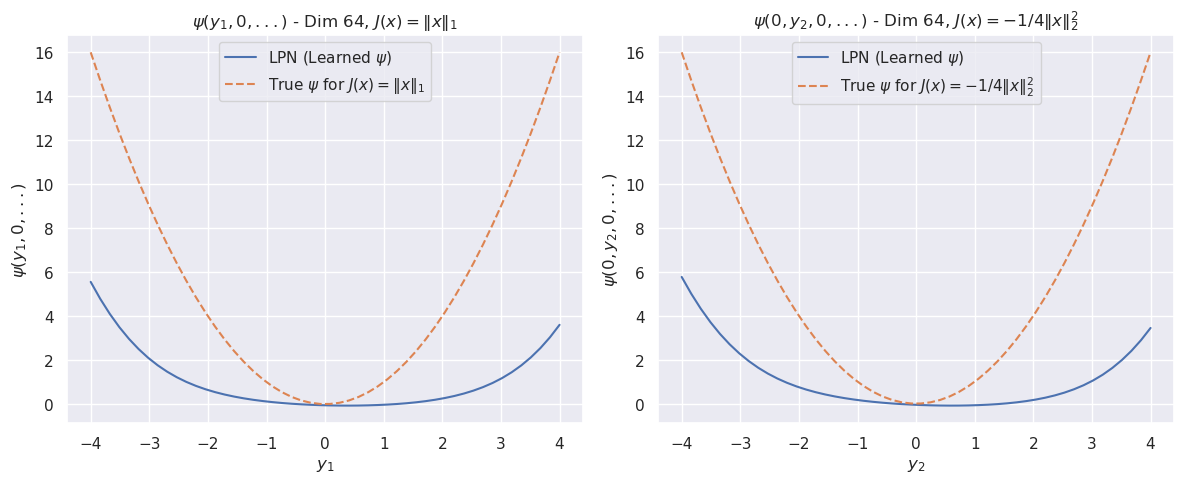

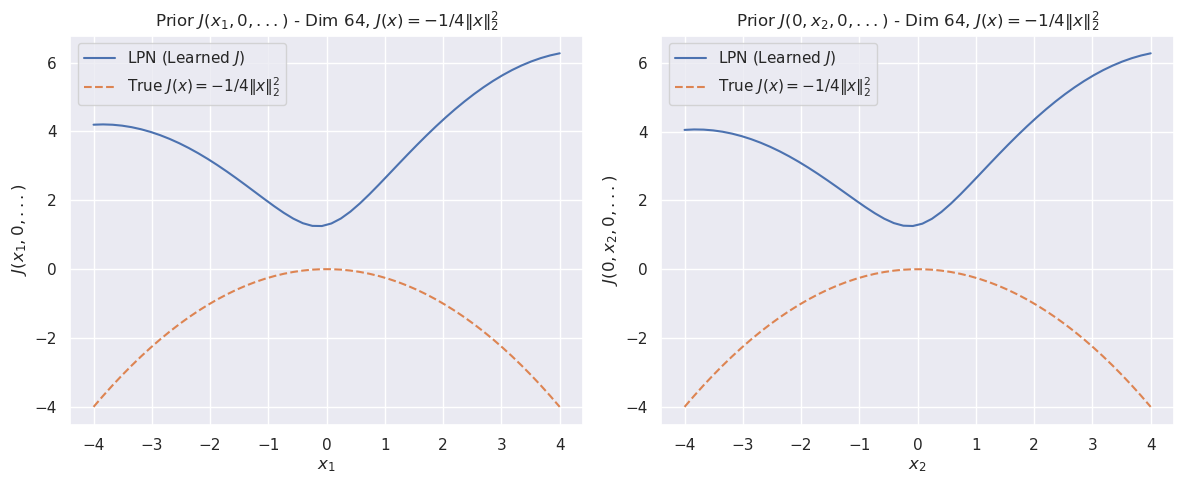

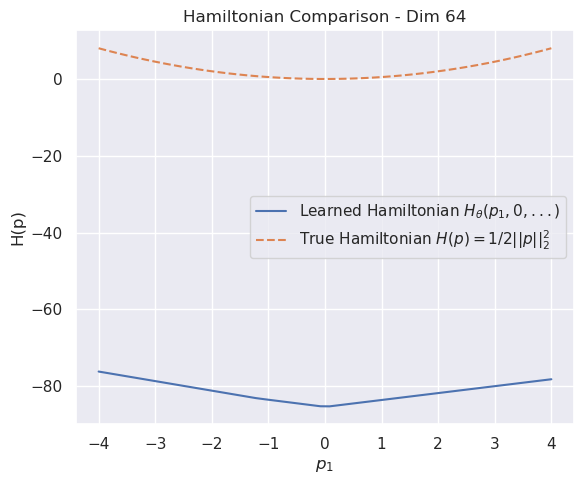

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

Generated G samples: G_samples_tensor shape torch.Size([40000, 1])


In [10]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 73281.8515625
iteration 0 loss 48651.390625


iteration 500 loss 192.8359375


iteration 1000 loss 128.4068145751953


iteration 1500 loss 91.35588836669922


iteration 2000 loss 72.7570571899414


iteration 2500 loss 63.98051071166992


iteration 3000 loss 59.34174728393555


iteration 3500 loss 55.8458366394043


iteration 4000 loss 52.46487808227539


iteration 4500 loss 49.03899383544922


iteration 5000 loss 45.63302230834961


iteration 5500 loss 42.307743072509766


iteration 6000 loss 39.07937240600586


iteration 6500 loss 35.95003128051758


iteration 7000 loss 32.90285873413086


iteration 7500 loss 29.95032501220703


iteration 8000 loss 27.119400024414062


iteration 8500 loss 24.43887710571289


iteration 9000 loss 21.925559997558594


iteration 9500 loss 19.640911102294922


iteration 10000 loss 17.590839385986328


iteration 10500 loss 15.785783767700195


iteration 11000 loss 14.18307113647461


iteration 11500 loss 12.705288887023926


iteration 12000 loss 11.474367141723633


iteration 12500 loss 10.541245460510254


iteration 13000 loss 9.67031192779541


iteration 13500 loss 9.020478248596191


iteration 14000 loss 8.366669654846191


iteration 14500 loss 7.728498458862305


iteration 15000 loss 7.237016201019287


iteration 15500 loss 6.666894912719727


iteration 16000 loss 6.207727909088135


iteration 16500 loss 5.8230390548706055


iteration 17000 loss 5.367496013641357


iteration 17500 loss 4.96053409576416


iteration 18000 loss 4.738667964935303


iteration 18500 loss 4.468201637268066


iteration 19000 loss 4.143331050872803


iteration 19500 loss 3.766505718231201


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 3.614290952682495


iteration 20500 loss 3.596558094024658


iteration 21000 loss 3.5741119384765625


iteration 21500 loss 3.5458760261535645


iteration 22000 loss 3.5106046199798584


iteration 22500 loss 3.4669687747955322


iteration 23000 loss 3.413649797439575


iteration 23500 loss 3.349327325820923


iteration 24000 loss 3.2726359367370605


iteration 24500 loss 3.182469129562378


iteration 25000 loss 3.0777432918548584


iteration 25500 loss 2.9577245712280273


iteration 26000 loss 2.823007822036743


iteration 26500 loss 2.677180290222168


iteration 27000 loss 2.54243803024292


iteration 27500 loss 2.4231600761413574


iteration 28000 loss 2.308974504470825


iteration 28500 loss 2.2003867626190186


iteration 29000 loss 2.0991039276123047


iteration 29500 loss 2.0154647827148438


iteration 30000 loss 1.9266167879104614


iteration 30500 loss 1.8567479848861694


iteration 31000 loss 1.7837713956832886


iteration 31500 loss 1.7193292379379272


iteration 32000 loss 1.6661765575408936


iteration 32500 loss 1.6053104400634766


iteration 33000 loss 1.5558927059173584


iteration 33500 loss 1.516953945159912


iteration 34000 loss 1.471045732498169


iteration 34500 loss 1.4181220531463623


iteration 35000 loss 1.384757161140442


iteration 35500 loss 1.3480428457260132


iteration 36000 loss 1.3050107955932617


iteration 36500 loss 1.2770240306854248


iteration 37000 loss 1.2524462938308716


iteration 37500 loss 1.2228412628173828


iteration 38000 loss 1.1879019737243652


iteration 38500 loss 1.1638314723968506


iteration 39000 loss 1.1450774669647217


iteration 39500 loss 1.1221626996994019


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 1.0946581363677979


iteration 40500 loss 1.0913341045379639


iteration 41000 loss 1.087256669998169


iteration 41500 loss 1.0823348760604858


iteration 42000 loss 1.07650625705719


iteration 42500 loss 1.069740891456604


iteration 43000 loss 1.0620635747909546


iteration 43500 loss 1.0535262823104858


iteration 44000 loss 1.0442678928375244


iteration 44500 loss 1.0344386100769043


iteration 45000 loss 1.0241856575012207


iteration 45500 loss 1.013646125793457


iteration 46000 loss 1.0032517910003662


iteration 46500 loss 0.9931722283363342


iteration 47000 loss 0.9833565950393677


iteration 47500 loss 0.973800003528595


iteration 48000 loss 0.9644446969032288


iteration 48500 loss 0.9552834630012512


iteration 49000 loss 0.9462990164756775


iteration 49500 loss 0.9374880790710449


iteration 50000 loss 0.9288235902786255


iteration 50500 loss 0.9202970266342163


iteration 51000 loss 0.9119032025337219


iteration 51500 loss 0.9036599397659302


iteration 52000 loss 0.8955261707305908


iteration 52500 loss 0.8875203132629395


iteration 53000 loss 0.8796411752700806


iteration 53500 loss 0.8718714714050293


iteration 54000 loss 0.8642162084579468


iteration 54500 loss 0.856650173664093


iteration 55000 loss 0.8491925597190857


iteration 55500 loss 0.8418706655502319


iteration 56000 loss 0.8346105217933655


iteration 56500 loss 0.8274409770965576


iteration 57000 loss 0.8203710913658142


iteration 57500 loss 0.8134037852287292


iteration 58000 loss 0.806498110294342


iteration 58500 loss 0.7996829748153687


iteration 59000 loss 0.7929849028587341


iteration 59500 loss 0.7863673567771912


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.7798342704772949


iteration 60500 loss 0.7791604995727539


iteration 61000 loss 0.7784468531608582


iteration 61500 loss 0.7777013182640076


iteration 62000 loss 0.776928186416626


iteration 62500 loss 0.7761327028274536


iteration 63000 loss 0.775320291519165


iteration 63500 loss 0.7744956016540527


iteration 64000 loss 0.7736626267433167


iteration 64500 loss 0.7728241086006165


iteration 65000 loss 0.7719833850860596


iteration 65500 loss 0.7711436152458191


iteration 66000 loss 0.7703052163124084


iteration 66500 loss 0.7694674730300903


iteration 67000 loss 0.7686330080032349


iteration 67500 loss 0.7678022980690002


iteration 68000 loss 0.7669738531112671


iteration 68500 loss 0.766150176525116


iteration 69000 loss 0.7653279304504395


iteration 69500 loss 0.7645089626312256


iteration 70000 loss 0.7636922597885132


iteration 70500 loss 0.7628774046897888


iteration 71000 loss 0.7620648145675659


iteration 71500 loss 0.7612534761428833


iteration 72000 loss 0.7604445219039917


iteration 72500 loss 0.7596368789672852


iteration 73000 loss 0.7588323950767517


iteration 73500 loss 0.7580287456512451


iteration 74000 loss 0.757226824760437


iteration 74500 loss 0.7564274072647095


iteration 75000 loss 0.7556290626525879


iteration 75500 loss 0.7548317909240723


iteration 76000 loss 0.7540359497070312


iteration 76500 loss 0.7532423138618469


iteration 77000 loss 0.7524495720863342


iteration 77500 loss 0.7516584992408752


iteration 78000 loss 0.7508693337440491


iteration 78500 loss 0.7500815987586975


iteration 79000 loss 0.7492957711219788


iteration 79500 loss 0.7485114932060242


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.7477290034294128


iteration 80500 loss 0.7476551532745361


iteration 81000 loss 0.7475820183753967


iteration 81500 loss 0.7475080490112305


iteration 82000 loss 0.747434139251709


iteration 82500 loss 0.7473601698875427


iteration 83000 loss 0.7472866773605347


iteration 83500 loss 0.7472128868103027


iteration 84000 loss 0.7471391558647156


iteration 84500 loss 0.7470657229423523


iteration 85000 loss 0.7469918727874756


iteration 85500 loss 0.7469185590744019


iteration 86000 loss 0.746845006942749


iteration 86500 loss 0.746771514415741


iteration 87000 loss 0.746698260307312


iteration 87500 loss 0.7466244697570801


iteration 88000 loss 0.7465515732765198


iteration 88500 loss 0.7464786171913147


iteration 89000 loss 0.7464050650596619


iteration 89500 loss 0.7463316321372986


iteration 90000 loss 0.746258556842804


iteration 90500 loss 0.7461855411529541


iteration 91000 loss 0.7461121082305908


iteration 91500 loss 0.7460389733314514


iteration 92000 loss 0.7459657788276672


iteration 92500 loss 0.7458928227424622


iteration 93000 loss 0.7458196878433228


iteration 93500 loss 0.7457464933395386


iteration 94000 loss 0.7456738948822021


iteration 94500 loss 0.7456003427505493


iteration 95000 loss 0.7455276250839233


iteration 95500 loss 0.7454547882080078


iteration 96000 loss 0.7453821301460266


iteration 96500 loss 0.7453085780143738


iteration 97000 loss 0.745235800743103


iteration 97500 loss 0.7451631426811218


iteration 98000 loss 0.7450904846191406


iteration 98500 loss 0.7450176477432251


iteration 99000 loss 0.7449449896812439


iteration 99500 loss 0.7448723316192627


Learning rate decreased to 1.0000000000000005e-09 at iteration 100000
iteration 100000 loss 0.7447994351387024


iteration 100500 loss 0.7447944283485413


iteration 101000 loss 0.7447898387908936


iteration 101500 loss 0.744784951210022


iteration 102000 loss 0.7447803616523743


iteration 102500 loss 0.7447758316993713


iteration 103000 loss 0.7447710633277893


iteration 103500 loss 0.7447664141654968


iteration 104000 loss 0.7447620034217834


iteration 104500 loss 0.7447572946548462


iteration 105000 loss 0.7447523474693298


iteration 105500 loss 0.7447474598884583


iteration 106000 loss 0.7447426319122314


iteration 106500 loss 0.7447380423545837


iteration 107000 loss 0.7447333931922913


iteration 107500 loss 0.744728684425354


iteration 108000 loss 0.7447242736816406


iteration 108500 loss 0.7447196245193481


iteration 109000 loss 0.7447147369384766


iteration 109500 loss 0.7447100281715393


iteration 110000 loss 0.7447055578231812


iteration 110500 loss 0.7447008490562439


iteration 111000 loss 0.7446959018707275


iteration 111500 loss 0.7446910738945007


iteration 112000 loss 0.7446866631507874


iteration 112500 loss 0.7446821331977844


iteration 113000 loss 0.7446773052215576


iteration 113500 loss 0.7446726560592651


iteration 114000 loss 0.7446681261062622


iteration 114500 loss 0.7446629405021667


iteration 115000 loss 0.7446586489677429


iteration 115500 loss 0.7446537613868713


iteration 116000 loss 0.7446494698524475


iteration 116500 loss 0.7446447014808655


iteration 117000 loss 0.7446401119232178


iteration 117500 loss 0.7446356415748596


iteration 118000 loss 0.7446306347846985


iteration 118500 loss 0.7446261048316956


iteration 119000 loss 0.7446214556694031


iteration 119500 loss 0.7446170449256897


Learning rate decreased to 1.0000000000000006e-10 at iteration 120000
iteration 120000 loss 0.7446123957633972


iteration 120500 loss 0.7446122169494629


iteration 121000 loss 0.7446120381355286


iteration 121500 loss 0.7446123361587524


iteration 122000 loss 0.7446121573448181


iteration 122500 loss 0.7446120977401733


iteration 123000 loss 0.7446119785308838


iteration 123500 loss 0.7446120977401733


iteration 124000 loss 0.7446120381355286


iteration 124500 loss 0.7446120977401733


iteration 125000 loss 0.7446119785308838


iteration 125500 loss 0.744611918926239


iteration 126000 loss 0.744611918926239


iteration 126500 loss 0.7446119785308838


iteration 127000 loss 0.7446119785308838


iteration 127500 loss 0.744611918926239


iteration 128000 loss 0.744611918926239


iteration 128500 loss 0.7446119785308838


iteration 129000 loss 0.7446117997169495


iteration 129500 loss 0.7446117997169495


iteration 130000 loss 0.7446117997169495


iteration 130500 loss 0.7446119785308838


iteration 131000 loss 0.7446120381355286


iteration 131500 loss 0.7446117997169495


iteration 132000 loss 0.7446118593215942


iteration 132500 loss 0.7446117401123047


iteration 133000 loss 0.7446116805076599


iteration 133500 loss 0.7446114420890808


iteration 134000 loss 0.744611382484436


iteration 134500 loss 0.744611382484436


iteration 135000 loss 0.7446115016937256


iteration 135500 loss 0.744611382484436


iteration 136000 loss 0.744611382484436


iteration 136500 loss 0.7446115016937256


iteration 137000 loss 0.744611382484436


iteration 137500 loss 0.7446116209030151


iteration 138000 loss 0.744611382484436


iteration 138500 loss 0.744611382484436


iteration 139000 loss 0.744611382484436


iteration 139500 loss 0.7446112036705017


Learning rate decreased to 1.0000000000000006e-11 at iteration 140000
iteration 140000 loss 0.744611382484436


iteration 140500 loss 0.7446113228797913


iteration 141000 loss 0.7446112036705017


iteration 141500 loss 0.7446112632751465


iteration 142000 loss 0.7446112632751465


iteration 142500 loss 0.7446113228797913


iteration 143000 loss 0.7446113228797913


iteration 143500 loss 0.7446113228797913


iteration 144000 loss 0.7446113228797913


iteration 144500 loss 0.7446113228797913


iteration 145000 loss 0.744611382484436


iteration 145500 loss 0.7446113228797913


iteration 146000 loss 0.7446112036705017


iteration 146500 loss 0.7446112036705017


iteration 147000 loss 0.7446112632751465


iteration 147500 loss 0.7446112632751465


iteration 148000 loss 0.7446112632751465


iteration 148500 loss 0.7446112632751465


iteration 149000 loss 0.7446112036705017


iteration 149500 loss 0.7446111440658569


iteration 150000 loss 0.7446112036705017


iteration 150500 loss 0.7446112036705017


iteration 151000 loss 0.7446113228797913


iteration 151500 loss 0.7446113228797913


iteration 152000 loss 0.7446112632751465


iteration 152500 loss 0.7446113228797913


iteration 153000 loss 0.7446113228797913


iteration 153500 loss 0.744611382484436


iteration 154000 loss 0.7446113228797913


iteration 154500 loss 0.7446113228797913


iteration 155000 loss 0.744611382484436


iteration 155500 loss 0.744611382484436


iteration 156000 loss 0.744611382484436


iteration 156500 loss 0.744611382484436


iteration 157000 loss 0.744611382484436


iteration 157500 loss 0.744611382484436


iteration 158000 loss 0.7446113228797913


iteration 158500 loss 0.7446112632751465


iteration 159000 loss 0.7446111440658569


iteration 159500 loss 0.7446111440658569


Learning rate decreased to 1.0000000000000006e-12 at iteration 160000
iteration 160000 loss 0.7446110844612122


iteration 160500 loss 0.7446110844612122


iteration 161000 loss 0.7446110844612122


iteration 161500 loss 0.7446110844612122


iteration 162000 loss 0.7446110844612122


iteration 162500 loss 0.7446110844612122


iteration 163000 loss 0.7446110844612122


iteration 163500 loss 0.7446110844612122


iteration 164000 loss 0.7446110844612122


iteration 164500 loss 0.7446110844612122


iteration 165000 loss 0.7446110844612122


iteration 165500 loss 0.7446110844612122


iteration 166000 loss 0.7446110844612122


iteration 166500 loss 0.7446110844612122


iteration 167000 loss 0.7446110844612122


iteration 167500 loss 0.7446110844612122


iteration 168000 loss 0.7446111440658569


iteration 168500 loss 0.7446111440658569


iteration 169000 loss 0.7446111440658569


iteration 169500 loss 0.7446111440658569


iteration 170000 loss 0.7446110844612122


iteration 170500 loss 0.7446111440658569


iteration 171000 loss 0.7446111440658569


iteration 171500 loss 0.7446112036705017


iteration 172000 loss 0.7446112036705017


iteration 172500 loss 0.7446112036705017


iteration 173000 loss 0.7446111440658569


iteration 173500 loss 0.7446111440658569


iteration 174000 loss 0.7446111440658569


iteration 174500 loss 0.7446111440658569


iteration 175000 loss 0.7446110844612122


iteration 175500 loss 0.7446110844612122


iteration 176000 loss 0.7446110844612122


iteration 176500 loss 0.7446110844612122


iteration 177000 loss 0.7446112036705017


iteration 177500 loss 0.7446112036705017


iteration 178000 loss 0.7446112036705017


iteration 178500 loss 0.7446112036705017


iteration 179000 loss 0.7446111440658569


iteration 179500 loss 0.7446110844612122


Learning rate decreased to 1.0000000000000007e-13 at iteration 180000
iteration 180000 loss 0.7446110844612122


iteration 180500 loss 0.7446110844612122


iteration 181000 loss 0.7446110844612122


iteration 181500 loss 0.7446110844612122


iteration 182000 loss 0.7446110844612122


iteration 182500 loss 0.7446110844612122


iteration 183000 loss 0.7446110844612122


iteration 183500 loss 0.7446110844612122


iteration 184000 loss 0.7446110844612122


iteration 184500 loss 0.7446110844612122


iteration 185000 loss 0.7446110844612122


iteration 185500 loss 0.7446110844612122


iteration 186000 loss 0.7446110844612122


iteration 186500 loss 0.7446110844612122


iteration 187000 loss 0.7446110844612122


iteration 187500 loss 0.7446110844612122


iteration 188000 loss 0.7446110844612122


iteration 188500 loss 0.7446110844612122


iteration 189000 loss 0.7446110844612122


iteration 189500 loss 0.7446110844612122


iteration 190000 loss 0.7446110844612122


iteration 190500 loss 0.7446110844612122


iteration 191000 loss 0.7446110844612122


iteration 191500 loss 0.7446110844612122


iteration 192000 loss 0.7446110844612122


iteration 192500 loss 0.7446110844612122


iteration 193000 loss 0.7446110844612122


iteration 193500 loss 0.7446110844612122


iteration 194000 loss 0.7446110844612122


iteration 194500 loss 0.7446110844612122


iteration 195000 loss 0.7446110844612122


iteration 195500 loss 0.7446110844612122


iteration 196000 loss 0.7446110844612122


iteration 196500 loss 0.7446110844612122


iteration 197000 loss 0.7446110844612122


iteration 197500 loss 0.7446110844612122


iteration 198000 loss 0.7446110844612122


iteration 198500 loss 0.7446110844612122


iteration 199000 loss 0.7446110844612122


iteration 199500 loss 0.7446110844612122


Learning rate decreased to 1.0000000000000008e-14 at iteration 200000
iteration 200000 loss 0.7446110844612122


iteration 200500 loss 0.7446110844612122


iteration 201000 loss 0.7446110844612122


iteration 201500 loss 0.7446110844612122


iteration 202000 loss 0.7446110844612122


iteration 202500 loss 0.7446110844612122


iteration 203000 loss 0.7446110844612122


iteration 203500 loss 0.7446110844612122


iteration 204000 loss 0.7446110844612122


iteration 204500 loss 0.7446110844612122


iteration 205000 loss 0.7446110844612122


iteration 205500 loss 0.7446110844612122


iteration 206000 loss 0.7446110844612122


iteration 206500 loss 0.7446110844612122


iteration 207000 loss 0.7446110844612122


iteration 207500 loss 0.7446110844612122


iteration 208000 loss 0.7446110844612122


iteration 208500 loss 0.7446110844612122


iteration 209000 loss 0.7446110844612122


iteration 209500 loss 0.7446110844612122


iteration 210000 loss 0.7446110844612122


iteration 210500 loss 0.7446110844612122


iteration 211000 loss 0.7446110844612122


iteration 211500 loss 0.7446110844612122


iteration 212000 loss 0.7446110844612122


iteration 212500 loss 0.7446110844612122


iteration 213000 loss 0.7446110844612122


iteration 213500 loss 0.7446110844612122


iteration 214000 loss 0.7446110844612122


iteration 214500 loss 0.7446110844612122


iteration 215000 loss 0.7446110844612122


iteration 215500 loss 0.7446110844612122


iteration 216000 loss 0.7446110844612122


iteration 216500 loss 0.7446110844612122


iteration 217000 loss 0.7446110844612122


iteration 217500 loss 0.7446110844612122


iteration 218000 loss 0.7446110844612122


iteration 218500 loss 0.7446110844612122


iteration 219000 loss 0.7446110844612122


iteration 219500 loss 0.7446110844612122


Learning rate decreased to 1.0000000000000009e-15 at iteration 220000
iteration 220000 loss 0.7446110844612122


iteration 220500 loss 0.7446110844612122


iteration 221000 loss 0.7446110844612122


iteration 221500 loss 0.7446110844612122


iteration 222000 loss 0.7446110844612122


iteration 222500 loss 0.7446110844612122


iteration 223000 loss 0.7446110844612122


iteration 223500 loss 0.7446110844612122


iteration 224000 loss 0.7446110844612122


iteration 224500 loss 0.7446110844612122


iteration 225000 loss 0.7446110844612122


iteration 225500 loss 0.7446110844612122


iteration 226000 loss 0.7446110844612122


iteration 226500 loss 0.7446110844612122


iteration 227000 loss 0.7446110844612122


iteration 227500 loss 0.7446110844612122


iteration 228000 loss 0.7446110844612122


iteration 228500 loss 0.7446110844612122


iteration 229000 loss 0.7446110844612122


iteration 229500 loss 0.7446110844612122


iteration 230000 loss 0.7446110844612122


iteration 230500 loss 0.7446110844612122


iteration 231000 loss 0.7446110844612122


iteration 231500 loss 0.7446110844612122


iteration 232000 loss 0.7446110844612122


iteration 232500 loss 0.7446110844612122


iteration 233000 loss 0.7446110844612122


iteration 233500 loss 0.7446110844612122


iteration 234000 loss 0.7446110844612122


iteration 234500 loss 0.7446110844612122


iteration 235000 loss 0.7446110844612122


iteration 235500 loss 0.7446110844612122


iteration 236000 loss 0.7446110844612122


iteration 236500 loss 0.7446110844612122


iteration 237000 loss 0.7446110844612122


iteration 237500 loss 0.7446110844612122


iteration 238000 loss 0.7446110844612122


iteration 238500 loss 0.7446110844612122


iteration 239000 loss 0.7446110844612122


iteration 239500 loss 0.7446110844612122


Learning rate decreased to 1.000000000000001e-16 at iteration 240000
iteration 240000 loss 0.7446110844612122


iteration 240500 loss 0.7446110844612122


iteration 241000 loss 0.7446110844612122


iteration 241500 loss 0.7446110844612122


iteration 242000 loss 0.7446110844612122


iteration 242500 loss 0.7446110844612122


iteration 243000 loss 0.7446110844612122


iteration 243500 loss 0.7446110844612122


iteration 244000 loss 0.7446110844612122


iteration 244500 loss 0.7446110844612122


iteration 245000 loss 0.7446110844612122


iteration 245500 loss 0.7446110844612122


iteration 246000 loss 0.7446110844612122


iteration 246500 loss 0.7446110844612122


iteration 247000 loss 0.7446110844612122


iteration 247500 loss 0.7446110844612122


iteration 248000 loss 0.7446110844612122


iteration 248500 loss 0.7446110844612122


iteration 249000 loss 0.7446110844612122


iteration 249500 loss 0.7446110844612122


iteration 250000 loss 0.7446110844612122


iteration 250500 loss 0.7446110844612122


iteration 251000 loss 0.7446110844612122


iteration 251500 loss 0.7446110844612122


iteration 252000 loss 0.7446110844612122


iteration 252500 loss 0.7446110844612122


iteration 253000 loss 0.7446110844612122


iteration 253500 loss 0.7446110844612122


iteration 254000 loss 0.7446110844612122


iteration 254500 loss 0.7446110844612122


iteration 255000 loss 0.7446110844612122


iteration 255500 loss 0.7446110844612122


iteration 256000 loss 0.7446110844612122


iteration 256500 loss 0.7446110844612122


iteration 257000 loss 0.7446110844612122


iteration 257500 loss 0.7446110844612122


iteration 258000 loss 0.7446110844612122


iteration 258500 loss 0.7446110844612122


iteration 259000 loss 0.7446110844612122


iteration 259500 loss 0.7446110844612122


Learning rate decreased to 1.000000000000001e-17 at iteration 260000
iteration 260000 loss 0.7446110844612122


iteration 260500 loss 0.7446110844612122


iteration 261000 loss 0.7446110844612122


iteration 261500 loss 0.7446110844612122


iteration 262000 loss 0.7446110844612122


iteration 262500 loss 0.7446110844612122


iteration 263000 loss 0.7446110844612122


iteration 263500 loss 0.7446110844612122


iteration 264000 loss 0.7446110844612122


iteration 264500 loss 0.7446110844612122


iteration 265000 loss 0.7446110844612122


iteration 265500 loss 0.7446110844612122


iteration 266000 loss 0.7446110844612122


iteration 266500 loss 0.7446110844612122


iteration 267000 loss 0.7446110844612122


iteration 267500 loss 0.7446110844612122


iteration 268000 loss 0.7446110844612122


iteration 268500 loss 0.7446110844612122


iteration 269000 loss 0.7446110844612122


iteration 269500 loss 0.7446110844612122


iteration 270000 loss 0.7446110844612122


iteration 270500 loss 0.7446110844612122


iteration 271000 loss 0.7446110844612122


iteration 271500 loss 0.7446110844612122


iteration 272000 loss 0.7446110844612122


iteration 272500 loss 0.7446110844612122


iteration 273000 loss 0.7446110844612122


iteration 273500 loss 0.7446110844612122


iteration 274000 loss 0.7446110844612122


iteration 274500 loss 0.7446110844612122


iteration 275000 loss 0.7446110844612122


iteration 275500 loss 0.7446110844612122


iteration 276000 loss 0.7446110844612122


iteration 276500 loss 0.7446110844612122


iteration 277000 loss 0.7446110844612122


iteration 277500 loss 0.7446110844612122


iteration 278000 loss 0.7446110844612122


iteration 278500 loss 0.7446110844612122


iteration 279000 loss 0.7446110844612122


iteration 279500 loss 0.7446110844612122


Learning rate decreased to 1.000000000000001e-18 at iteration 280000
iteration 280000 loss 0.7446110844612122


iteration 280500 loss 0.7446110844612122


iteration 281000 loss 0.7446110844612122


iteration 281500 loss 0.7446110844612122


iteration 282000 loss 0.7446110844612122


iteration 282500 loss 0.7446110844612122


iteration 283000 loss 0.7446110844612122


iteration 283500 loss 0.7446110844612122


iteration 284000 loss 0.7446110844612122


iteration 284500 loss 0.7446110844612122


iteration 285000 loss 0.7446110844612122


iteration 285500 loss 0.7446110844612122


iteration 286000 loss 0.7446110844612122


iteration 286500 loss 0.7446110844612122


iteration 287000 loss 0.7446110844612122


iteration 287500 loss 0.7446110844612122


iteration 288000 loss 0.7446110844612122


iteration 288500 loss 0.7446110844612122


iteration 289000 loss 0.7446110844612122


iteration 289500 loss 0.7446110844612122


iteration 290000 loss 0.7446110844612122


iteration 290500 loss 0.7446110844612122


iteration 291000 loss 0.7446110844612122


iteration 291500 loss 0.7446110844612122


iteration 292000 loss 0.7446110844612122


iteration 292500 loss 0.7446110844612122


iteration 293000 loss 0.7446110844612122


iteration 293500 loss 0.7446110844612122


iteration 294000 loss 0.7446110844612122


iteration 294500 loss 0.7446110844612122


iteration 295000 loss 0.7446110844612122


iteration 295500 loss 0.7446110844612122


iteration 296000 loss 0.7446110844612122


iteration 296500 loss 0.7446110844612122


iteration 297000 loss 0.7446110844612122


iteration 297500 loss 0.7446110844612122


iteration 298000 loss 0.7446110844612122


iteration 298500 loss 0.7446110844612122


iteration 299000 loss 0.7446110844612122


iteration 299500 loss 0.7446110844612122


Learning rate decreased to 1.000000000000001e-19 at iteration 300000
iteration 300000 loss 0.7446110844612122


iteration 300500 loss 0.7446110844612122


iteration 301000 loss 0.7446110844612122


iteration 301500 loss 0.7446110844612122


iteration 302000 loss 0.7446110844612122


iteration 302500 loss 0.7446110844612122


iteration 303000 loss 0.7446110844612122


iteration 303500 loss 0.7446110844612122


iteration 304000 loss 0.7446110844612122


iteration 304500 loss 0.7446110844612122


iteration 305000 loss 0.7446110844612122


iteration 305500 loss 0.7446110844612122


iteration 306000 loss 0.7446110844612122


iteration 306500 loss 0.7446110844612122


iteration 307000 loss 0.7446110844612122


iteration 307500 loss 0.7446110844612122


iteration 308000 loss 0.7446110844612122


iteration 308500 loss 0.7446110844612122


iteration 309000 loss 0.7446110844612122


iteration 309500 loss 0.7446110844612122


iteration 310000 loss 0.7446110844612122


iteration 310500 loss 0.7446110844612122


iteration 311000 loss 0.7446110844612122


iteration 311500 loss 0.7446110844612122


iteration 312000 loss 0.7446110844612122


iteration 312500 loss 0.7446110844612122


iteration 313000 loss 0.7446110844612122


iteration 313500 loss 0.7446110844612122


iteration 314000 loss 0.7446110844612122


iteration 314500 loss 0.7446110844612122


iteration 315000 loss 0.7446110844612122


iteration 315500 loss 0.7446110844612122


iteration 316000 loss 0.7446110844612122


iteration 316500 loss 0.7446110844612122


iteration 317000 loss 0.7446110844612122


iteration 317500 loss 0.7446110844612122


iteration 318000 loss 0.7446110844612122


iteration 318500 loss 0.7446110844612122


iteration 319000 loss 0.7446110844612122


iteration 319500 loss 0.7446110844612122


Learning rate decreased to 1.0000000000000011e-20 at iteration 320000
iteration 320000 loss 0.7446110844612122


iteration 320500 loss 0.7446110844612122


iteration 321000 loss 0.7446110844612122


iteration 321500 loss 0.7446110844612122


iteration 322000 loss 0.7446110844612122


iteration 322500 loss 0.7446110844612122


iteration 323000 loss 0.7446110844612122


iteration 323500 loss 0.7446110844612122


iteration 324000 loss 0.7446110844612122


iteration 324500 loss 0.7446110844612122


iteration 325000 loss 0.7446110844612122


iteration 325500 loss 0.7446110844612122


iteration 326000 loss 0.7446110844612122


iteration 326500 loss 0.7446110844612122


iteration 327000 loss 0.7446110844612122


iteration 327500 loss 0.7446110844612122


iteration 328000 loss 0.7446110844612122


iteration 328500 loss 0.7446110844612122


iteration 329000 loss 0.7446110844612122


iteration 329500 loss 0.7446110844612122


iteration 330000 loss 0.7446110844612122


iteration 330500 loss 0.7446110844612122


iteration 331000 loss 0.7446110844612122


iteration 331500 loss 0.7446110844612122


iteration 332000 loss 0.7446110844612122


iteration 332500 loss 0.7446110844612122


iteration 333000 loss 0.7446110844612122


iteration 333500 loss 0.7446110844612122


iteration 334000 loss 0.7446110844612122


iteration 334500 loss 0.7446110844612122


iteration 335000 loss 0.7446110844612122


iteration 335500 loss 0.7446110844612122


iteration 336000 loss 0.7446110844612122


iteration 336500 loss 0.7446110844612122


iteration 337000 loss 0.7446110844612122


iteration 337500 loss 0.7446110844612122


iteration 338000 loss 0.7446110844612122


iteration 338500 loss 0.7446110844612122


iteration 339000 loss 0.7446110844612122


iteration 339500 loss 0.7446110844612122


Learning rate decreased to 1.0000000000000012e-21 at iteration 340000
iteration 340000 loss 0.7446110844612122


iteration 340500 loss 0.7446110844612122


iteration 341000 loss 0.7446110844612122


iteration 341500 loss 0.7446110844612122


iteration 342000 loss 0.7446110844612122


iteration 342500 loss 0.7446110844612122


iteration 343000 loss 0.7446110844612122


iteration 343500 loss 0.7446110844612122


iteration 344000 loss 0.7446110844612122


iteration 344500 loss 0.7446110844612122


iteration 345000 loss 0.7446110844612122


iteration 345500 loss 0.7446110844612122


iteration 346000 loss 0.7446110844612122


iteration 346500 loss 0.7446110844612122


iteration 347000 loss 0.7446110844612122


iteration 347500 loss 0.7446110844612122


iteration 348000 loss 0.7446110844612122


iteration 348500 loss 0.7446110844612122


iteration 349000 loss 0.7446110844612122


iteration 349500 loss 0.7446110844612122


iteration 350000 loss 0.7446110844612122


iteration 350500 loss 0.7446110844612122


iteration 351000 loss 0.7446110844612122


iteration 351500 loss 0.7446110844612122


iteration 352000 loss 0.7446110844612122


iteration 352500 loss 0.7446110844612122


iteration 353000 loss 0.7446110844612122


iteration 353500 loss 0.7446110844612122


iteration 354000 loss 0.7446110844612122


iteration 354500 loss 0.7446110844612122


iteration 355000 loss 0.7446110844612122


iteration 355500 loss 0.7446110844612122


iteration 356000 loss 0.7446110844612122


iteration 356500 loss 0.7446110844612122


iteration 357000 loss 0.7446110844612122


iteration 357500 loss 0.7446110844612122


iteration 358000 loss 0.7446110844612122


iteration 358500 loss 0.7446110844612122


iteration 359000 loss 0.7446110844612122


iteration 359500 loss 0.7446110844612122


Learning rate decreased to 1.0000000000000012e-22 at iteration 360000
iteration 360000 loss 0.7446110844612122


iteration 360500 loss 0.7446110844612122


iteration 361000 loss 0.7446110844612122


iteration 361500 loss 0.7446110844612122


iteration 362000 loss 0.7446110844612122


iteration 362500 loss 0.7446110844612122


iteration 363000 loss 0.7446110844612122


iteration 363500 loss 0.7446110844612122


iteration 364000 loss 0.7446110844612122


iteration 364500 loss 0.7446110844612122


iteration 365000 loss 0.7446110844612122


iteration 365500 loss 0.7446110844612122


iteration 366000 loss 0.7446110844612122


iteration 366500 loss 0.7446110844612122


iteration 367000 loss 0.7446110844612122


iteration 367500 loss 0.7446110844612122


iteration 368000 loss 0.7446110844612122


iteration 368500 loss 0.7446110844612122


iteration 369000 loss 0.7446110844612122


iteration 369500 loss 0.7446110844612122


iteration 370000 loss 0.7446110844612122


iteration 370500 loss 0.7446110844612122


iteration 371000 loss 0.7446110844612122


iteration 371500 loss 0.7446110844612122


iteration 372000 loss 0.7446110844612122


iteration 372500 loss 0.7446110844612122


iteration 373000 loss 0.7446110844612122


iteration 373500 loss 0.7446110844612122


iteration 374000 loss 0.7446110844612122


iteration 374500 loss 0.7446110844612122


iteration 375000 loss 0.7446110844612122


iteration 375500 loss 0.7446110844612122


iteration 376000 loss 0.7446110844612122


iteration 376500 loss 0.7446110844612122


iteration 377000 loss 0.7446110844612122


iteration 377500 loss 0.7446110844612122


iteration 378000 loss 0.7446110844612122


iteration 378500 loss 0.7446110844612122


iteration 379000 loss 0.7446110844612122


iteration 379500 loss 0.7446110844612122


Learning rate decreased to 1.0000000000000013e-23 at iteration 380000
iteration 380000 loss 0.7446110844612122


iteration 380500 loss 0.7446110844612122


iteration 381000 loss 0.7446110844612122


iteration 381500 loss 0.7446110844612122


iteration 382000 loss 0.7446110844612122


iteration 382500 loss 0.7446110844612122


iteration 383000 loss 0.7446110844612122


iteration 383500 loss 0.7446110844612122


iteration 384000 loss 0.7446110844612122


iteration 384500 loss 0.7446110844612122


iteration 385000 loss 0.7446110844612122


iteration 385500 loss 0.7446110844612122


iteration 386000 loss 0.7446110844612122


iteration 386500 loss 0.7446110844612122


iteration 387000 loss 0.7446110844612122


iteration 387500 loss 0.7446110844612122


iteration 388000 loss 0.7446110844612122


iteration 388500 loss 0.7446110844612122


iteration 389000 loss 0.7446110844612122


iteration 389500 loss 0.7446110844612122


iteration 390000 loss 0.7446110844612122


iteration 390500 loss 0.7446110844612122


iteration 391000 loss 0.7446110844612122


iteration 391500 loss 0.7446110844612122


iteration 392000 loss 0.7446110844612122


iteration 392500 loss 0.7446110844612122


iteration 393000 loss 0.7446110844612122


iteration 393500 loss 0.7446110844612122


iteration 394000 loss 0.7446110844612122


iteration 394500 loss 0.7446110844612122


iteration 395000 loss 0.7446110844612122


iteration 395500 loss 0.7446110844612122


iteration 396000 loss 0.7446110844612122


iteration 396500 loss 0.7446110844612122


iteration 397000 loss 0.7446110844612122


iteration 397500 loss 0.7446110844612122


iteration 398000 loss 0.7446110844612122


iteration 398500 loss 0.7446110844612122


iteration 399000 loss 0.7446110844612122


iteration 399500 loss 0.7446110844612122


Learning rate decreased to 1.0000000000000014e-24 at iteration 400000
iteration 400000 loss 0.7446110844612122


iteration 400500 loss 0.7446110844612122


iteration 401000 loss 0.7446110844612122


iteration 401500 loss 0.7446110844612122


iteration 402000 loss 0.7446110844612122


iteration 402500 loss 0.7446110844612122


iteration 403000 loss 0.7446110844612122


iteration 403500 loss 0.7446110844612122


iteration 404000 loss 0.7446110844612122


iteration 404500 loss 0.7446110844612122


iteration 405000 loss 0.7446110844612122


iteration 405500 loss 0.7446110844612122


iteration 406000 loss 0.7446110844612122


iteration 406500 loss 0.7446110844612122


iteration 407000 loss 0.7446110844612122


iteration 407500 loss 0.7446110844612122


iteration 408000 loss 0.7446110844612122


iteration 408500 loss 0.7446110844612122


iteration 409000 loss 0.7446110844612122


iteration 409500 loss 0.7446110844612122


iteration 410000 loss 0.7446110844612122


iteration 410500 loss 0.7446110844612122


iteration 411000 loss 0.7446110844612122


iteration 411500 loss 0.7446110844612122


iteration 412000 loss 0.7446110844612122


iteration 412500 loss 0.7446110844612122


iteration 413000 loss 0.7446110844612122


iteration 413500 loss 0.7446110844612122


iteration 414000 loss 0.7446110844612122


iteration 414500 loss 0.7446110844612122


iteration 415000 loss 0.7446110844612122


iteration 415500 loss 0.7446110844612122


iteration 416000 loss 0.7446110844612122


iteration 416500 loss 0.7446110844612122


iteration 417000 loss 0.7446110844612122


iteration 417500 loss 0.7446110844612122


iteration 418000 loss 0.7446110844612122


iteration 418500 loss 0.7446110844612122


iteration 419000 loss 0.7446110844612122


iteration 419500 loss 0.7446110844612122


Learning rate decreased to 1.0000000000000014e-25 at iteration 420000
iteration 420000 loss 0.7446110844612122


iteration 420500 loss 0.7446110844612122


iteration 421000 loss 0.7446110844612122


iteration 421500 loss 0.7446110844612122


iteration 422000 loss 0.7446110844612122


iteration 422500 loss 0.7446110844612122


iteration 423000 loss 0.7446110844612122


iteration 423500 loss 0.7446110844612122


iteration 424000 loss 0.7446110844612122


iteration 424500 loss 0.7446110844612122


iteration 425000 loss 0.7446110844612122


iteration 425500 loss 0.7446110844612122


iteration 426000 loss 0.7446110844612122


iteration 426500 loss 0.7446110844612122


iteration 427000 loss 0.7446110844612122


iteration 427500 loss 0.7446110844612122


iteration 428000 loss 0.7446110844612122


iteration 428500 loss 0.7446110844612122


iteration 429000 loss 0.7446110844612122


iteration 429500 loss 0.7446110844612122


iteration 430000 loss 0.7446110844612122


iteration 430500 loss 0.7446110844612122


iteration 431000 loss 0.7446110844612122


iteration 431500 loss 0.7446110844612122


iteration 432000 loss 0.7446110844612122


iteration 432500 loss 0.7446110844612122


iteration 433000 loss 0.7446110844612122


iteration 433500 loss 0.7446110844612122


iteration 434000 loss 0.7446110844612122


iteration 434500 loss 0.7446110844612122


iteration 435000 loss 0.7446110844612122


iteration 435500 loss 0.7446110844612122


iteration 436000 loss 0.7446110844612122


iteration 436500 loss 0.7446110844612122


iteration 437000 loss 0.7446110844612122


iteration 437500 loss 0.7446110844612122


iteration 438000 loss 0.7446110844612122


iteration 438500 loss 0.7446110844612122


iteration 439000 loss 0.7446110844612122


iteration 439500 loss 0.7446110844612122


Learning rate decreased to 1.0000000000000015e-26 at iteration 440000
iteration 440000 loss 0.7446110844612122


iteration 440500 loss 0.7446110844612122


iteration 441000 loss 0.7446110844612122


iteration 441500 loss 0.7446110844612122


iteration 442000 loss 0.7446110844612122


iteration 442500 loss 0.7446110844612122


iteration 443000 loss 0.7446110844612122


iteration 443500 loss 0.7446110844612122


iteration 444000 loss 0.7446110844612122


iteration 444500 loss 0.7446110844612122


iteration 445000 loss 0.7446110844612122


iteration 445500 loss 0.7446110844612122


iteration 446000 loss 0.7446110844612122


iteration 446500 loss 0.7446110844612122


iteration 447000 loss 0.7446110844612122


iteration 447500 loss 0.7446110844612122


iteration 448000 loss 0.7446110844612122


iteration 448500 loss 0.7446110844612122


iteration 449000 loss 0.7446110844612122


iteration 449500 loss 0.7446110844612122


iteration 450000 loss 0.7446110844612122


iteration 450500 loss 0.7446110844612122


iteration 451000 loss 0.7446110844612122


iteration 451500 loss 0.7446110844612122


iteration 452000 loss 0.7446110844612122


iteration 452500 loss 0.7446110844612122


iteration 453000 loss 0.7446110844612122


iteration 453500 loss 0.7446110844612122


iteration 454000 loss 0.7446110844612122


iteration 454500 loss 0.7446110844612122


iteration 455000 loss 0.7446110844612122


iteration 455500 loss 0.7446110844612122


iteration 456000 loss 0.7446110844612122


iteration 456500 loss 0.7446110844612122


iteration 457000 loss 0.7446110844612122


iteration 457500 loss 0.7446110844612122


iteration 458000 loss 0.7446110844612122


iteration 458500 loss 0.7446110844612122


iteration 459000 loss 0.7446110844612122


iteration 459500 loss 0.7446110844612122


Learning rate decreased to 1.0000000000000015e-27 at iteration 460000
iteration 460000 loss 0.7446110844612122


iteration 460500 loss 0.7446110844612122


iteration 461000 loss 0.7446110844612122


iteration 461500 loss 0.7446110844612122


iteration 462000 loss 0.7446110844612122


iteration 462500 loss 0.7446110844612122


iteration 463000 loss 0.7446110844612122


iteration 463500 loss 0.7446110844612122


iteration 464000 loss 0.7446110844612122


iteration 464500 loss 0.7446110844612122


iteration 465000 loss 0.7446110844612122


iteration 465500 loss 0.7446110844612122


iteration 466000 loss 0.7446110844612122


iteration 466500 loss 0.7446110844612122


iteration 467000 loss 0.7446110844612122


iteration 467500 loss 0.7446110844612122


iteration 468000 loss 0.7446110844612122


iteration 468500 loss 0.7446110844612122


iteration 469000 loss 0.7446110844612122


iteration 469500 loss 0.7446110844612122


iteration 470000 loss 0.7446110844612122


iteration 470500 loss 0.7446110844612122


iteration 471000 loss 0.7446110844612122


iteration 471500 loss 0.7446110844612122


iteration 472000 loss 0.7446110844612122


iteration 472500 loss 0.7446110844612122


iteration 473000 loss 0.7446110844612122


iteration 473500 loss 0.7446110844612122


iteration 474000 loss 0.7446110844612122


iteration 474500 loss 0.7446110844612122


iteration 475000 loss 0.7446110844612122


iteration 475500 loss 0.7446110844612122


iteration 476000 loss 0.7446110844612122


iteration 476500 loss 0.7446110844612122


iteration 477000 loss 0.7446110844612122


iteration 477500 loss 0.7446110844612122


iteration 478000 loss 0.7446110844612122


iteration 478500 loss 0.7446110844612122


iteration 479000 loss 0.7446110844612122


iteration 479500 loss 0.7446110844612122


Learning rate decreased to 1.0000000000000015e-28 at iteration 480000
iteration 480000 loss 0.7446110844612122


iteration 480500 loss 0.7446110844612122


iteration 481000 loss 0.7446110844612122


iteration 481500 loss 0.7446110844612122


iteration 482000 loss 0.7446110844612122


iteration 482500 loss 0.7446110844612122


iteration 483000 loss 0.7446110844612122


iteration 483500 loss 0.7446110844612122


iteration 484000 loss 0.7446110844612122


iteration 484500 loss 0.7446110844612122


iteration 485000 loss 0.7446110844612122


iteration 485500 loss 0.7446110844612122


iteration 486000 loss 0.7446110844612122


iteration 486500 loss 0.7446110844612122


iteration 487000 loss 0.7446110844612122


iteration 487500 loss 0.7446110844612122


iteration 488000 loss 0.7446110844612122


iteration 488500 loss 0.7446110844612122


iteration 489000 loss 0.7446110844612122


iteration 489500 loss 0.7446110844612122


iteration 490000 loss 0.7446110844612122


iteration 490500 loss 0.7446110844612122


iteration 491000 loss 0.7446110844612122


iteration 491500 loss 0.7446110844612122


iteration 492000 loss 0.7446110844612122


iteration 492500 loss 0.7446110844612122


iteration 493000 loss 0.7446110844612122


iteration 493500 loss 0.7446110844612122


iteration 494000 loss 0.7446110844612122


iteration 494500 loss 0.7446110844612122


iteration 495000 loss 0.7446110844612122


iteration 495500 loss 0.7446110844612122


iteration 496000 loss 0.7446110844612122


iteration 496500 loss 0.7446110844612122


iteration 497000 loss 0.7446110844612122


iteration 497500 loss 0.7446110844612122


iteration 498000 loss 0.7446110844612122


iteration 498500 loss 0.7446110844612122


iteration 499000 loss 0.7446110844612122


iteration 499500 loss 0.7446110844612122


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


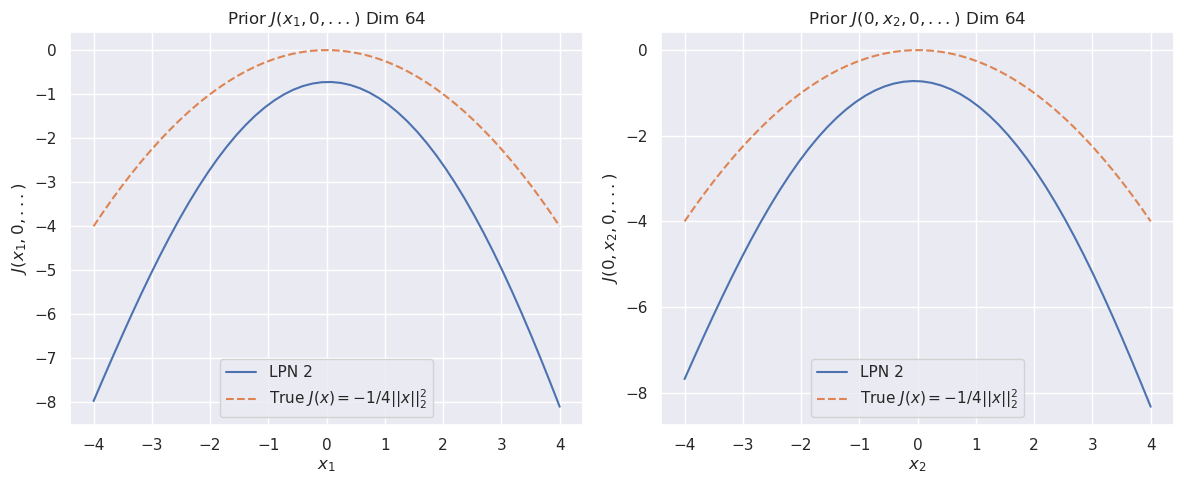

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.25 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)